# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor


In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Зафиксируем начальное значение

In [3]:
df1=df

Признаки


* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
*  PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак

* Price — цена (евро)

Проверим на наличие дубликатов
при наличии удалим их

In [4]:
df.duplicated().sum()

4

In [5]:
df = df.drop_duplicates()


In [6]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

DateCrawled - 0%
Price - 0%
VehicleType - 11%
RegistrationYear - 0%
Gearbox - 6%
Power - 0%
Model - 6%
Kilometer - 0%
RegistrationMonth - 0%
FuelType - 9%
Brand - 0%
NotRepaired - 20%
DateCreated - 0%
NumberOfPictures - 0%
PostalCode - 0%
LastSeen - 0%



пропуски следующим образом: 

```python
    
    (df.isnull().sum() * 100 / len(df)).round()
    
```


<AxesSubplot:>

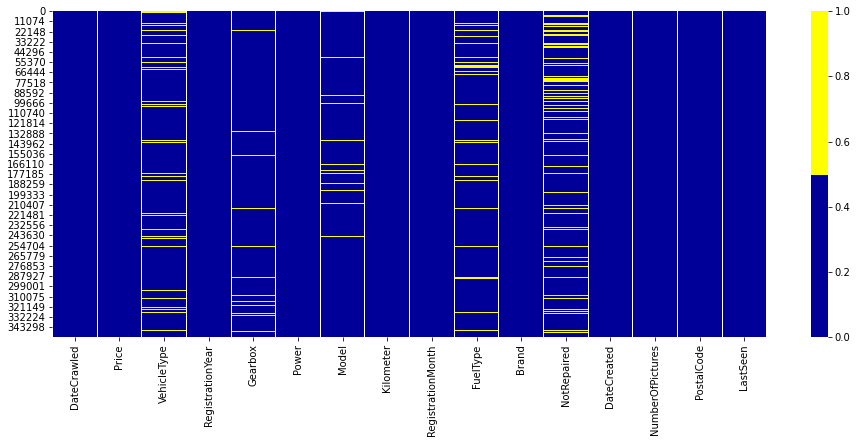

In [7]:
colum = df.columns
fig = plt.figure(figsize=(16,6))
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[colum].isnull(), cmap=sns.color_palette(colours))

Удалим пропуски в столбце с моделью, так как она влияет на цену



In [8]:
df['Model'] = df['Model'].fillna("unknown")


/tmp/ipykernel_137/1822146202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Model'] = df['Model'].fillna("unknown")


In [9]:
df['NotRepaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Заполним пропуски в столбце ремонт на значение нет, так как пропуски скорее всего значят отсутствие ремонта

In [10]:
df['NotRepaired'] = df['NotRepaired'].fillna("unknown")

/tmp/ipykernel_137/661175593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NotRepaired'] = df['NotRepaired'].fillna("unknown")


Заменим пропуски модойй в столбцах:
* VehicleType  - тип автомобильного кузова
* Gearbox - тип коробки передач
* FuelType -  тип топлива

In [11]:
df['VehicleType'] = df['VehicleType'].fillna(df['VehicleType'].mode().values[0])
df['Gearbox'] = df['Gearbox'].fillna(df['Gearbox'].mode().values[0])
df['FuelType'] = df['FuelType'].fillna(df['FuelType'].mode().values[0])

/tmp/ipykernel_137/1518722730.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['VehicleType'] = df['VehicleType'].fillna(df['VehicleType'].mode().values[0])
/tmp/ipykernel_137/1518722730.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Gearbox'] = df['Gearbox'].fillna(df['Gearbox'].mode().values[0])
/tmp/ipykernel_137/1518722730.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea


    
```python
# пример кода для работы с пропусками
data[column1] = data.groupby([column2, column3])[column1].transform(
    lambda x: x.fillna(value=(x.mode()[0] if not x.mode().empty else "unknown")))
```

Проверим распределение и удалим выбросы

In [12]:
df.describe()


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Проверим даты скачиания

In [13]:
df['DateCrawled'].max()

'2016-04-07 14:36:58'

In [14]:
df['DateCrawled'].min()

'2016-03-05 14:06:22'

Так как объявления в 2016, то регистрациятне может быть старше 2016, удалим выбросы по нижней границе и значения старше 2016 года

In [15]:
q75 = df['RegistrationYear'].quantile(0.75)
q25 = df['RegistrationYear'].quantile(0.25)
intr_qr = q75-q25
min = q25-(1.5*intr_qr)
df['RegistrationYear'].loc[df['RegistrationYear'] < min] = np.nan
df['RegistrationYear'].loc[df['RegistrationYear'] > 2016] = np.nan


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

так как в 2016 году Лидирующую строчку занял Bugatti Chiron - мощность 1500 лошадиных сил Об этом сообщает "Рамблер", то 
удалим строки в которых мощность больше 1500

In [16]:
df['Power'].loc[df['Power'] > 1500] = np.nan

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Так как в NumberOfPictures значения 0, удалим столбец

Удалим 
* RegistrationMonth 
* DateCreated 
* PostalCode LastSeen

In [17]:
df = df.drop(['NumberOfPictures','RegistrationMonth', 'DateCreated' , 'PostalCode', 'LastSeen', 'DateCrawled'],axis = 1)

Посмотри выбросы по цене

<AxesSubplot:xlabel='Price', ylabel='Count'>

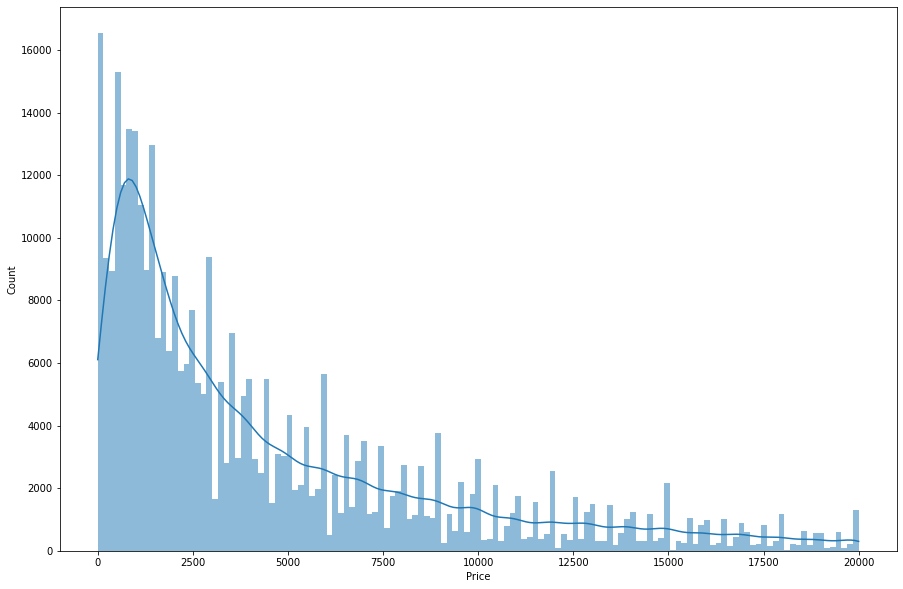

In [18]:
fig = plt.figure(figsize=(15,10))
sns.histplot(df['Price'], kde=True, linewidth=0)


<AxesSubplot:>

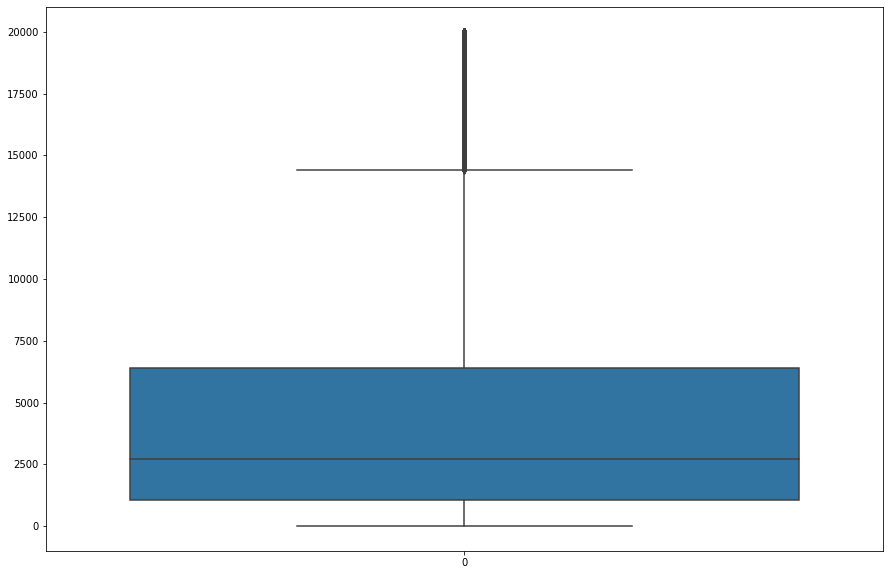

In [19]:
fig = plt.figure(figsize=(15,10))
sns.boxplot(data=df['Price'])

удалим строки с ценной меньше 100

In [20]:
df['Price'].loc[df['Price'] < 10] = np.nan

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [21]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Price - 3%
VehicleType - 0%
RegistrationYear - 6%
Gearbox - 0%
Power - 0%
Model - 0%
Kilometer - 0%
FuelType - 0%
Brand - 0%
NotRepaired - 0%


In [22]:
df = df.dropna()

In [23]:
print(df1.shape, df.shape, 1 - (df.shape[0]/df1.shape[0]))

(354369, 16) (322886, 10) 0.08884242131789177


Удалили выбросы, аномалии, дубликаты

Проверим корреляцию

In [24]:
df.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.571791,0.473784,-0.363195
RegistrationYear,0.571791,1.000000,0.131232,-0.355146
Power,0.473784,0.131232,1.000000,0.066458
Kilometer,-0.363195,-0.355146,0.066458,1.000000


Корреляции больше 0.8 нет. 

## Обучение моделей

In [25]:
RNS = 12345

In [26]:
df['VehicleType'].astype('category')
df['Gearbox'].astype('category')
df['Model'].astype('category')
df['FuelType'].astype('category')
df['Brand'].astype('category')
df['NotRepaired'].astype('category')

0         unknown
1             yes
2         unknown
3              no
4              no
           ...   
354363         no
354365    unknown
354366         no
354367         no
354368    unknown
Name: NotRepaired, Length: 322886, dtype: category
Categories (3, object): ['no', 'unknown', 'yes']

Применим к категориальным данным метод LabelEncoder()

In [34]:
labelencoder = LabelEncoder()
df['VehicleType']= labelencoder.fit_transform(df['VehicleType'])
df['Gearbox']= labelencoder.fit_transform(df['Gearbox'])
df['Model']= labelencoder.fit_transform(df['Model'])
df['FuelType']= labelencoder.fit_transform(df['FuelType'])
df['Brand']= labelencoder.fit_transform(df['Brand'])
df['NotRepaired'] = labelencoder.fit_transform(df['NotRepaired'])

 Есть более эффективные способы кодирования. Например:
    
```python
LabelEncoder().fit_transform(df)
```


```python
    df[cat_columns].apply(LabelEncoder().fit_transform)
```

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322886 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             322886 non-null  float64
 1   VehicleType       322886 non-null  int64  
 2   RegistrationYear  322886 non-null  float64
 3   Gearbox           322886 non-null  int64  
 4   Power             322886 non-null  float64
 5   Model             322886 non-null  int64  
 6   Kilometer         322886 non-null  int64  
 7   FuelType          322886 non-null  int64  
 8   Brand             322886 non-null  int64  
 9   NotRepaired       322886 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 27.1 MB


In [36]:
X = df.drop('Price',axis=1)
y = df['Price']

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = RNS)

Построим три модели 
RandomForestRegressor, LightGBM (LGBMRegressor) и CatBoost (CatBoostRegressor).

In [38]:
result = pd.DataFrame(columns=['RMSE','Time_fit', 'Time_predict'])


In [32]:
model_CBR = CatBoostRegressor(loss_function='RMSE')
parameters = {'depth': [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [30, 50, 100]
             }
grid = GridSearchCV(estimator=model_CBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(x_train, y_train)



print(" Results from Grid Search " )

print("\n The best parameters:\n", grid.best_params_)

0:	learn: 4509.2508370	total: 66.3ms	remaining: 1.92s
1:	learn: 4479.8061831	total: 82.2ms	remaining: 1.15s
2:	learn: 4450.6364402	total: 98.2ms	remaining: 883ms
3:	learn: 4421.3516554	total: 114ms	remaining: 740ms
4:	learn: 4393.0619071	total: 130ms	remaining: 648ms
5:	learn: 4364.6392131	total: 145ms	remaining: 582ms
6:	learn: 4336.4413871	total: 161ms	remaining: 529ms
7:	learn: 4309.2270096	total: 177ms	remaining: 486ms
8:	learn: 4281.4767685	total: 192ms	remaining: 448ms
9:	learn: 4254.0048419	total: 209ms	remaining: 418ms
10:	learn: 4227.3118044	total: 224ms	remaining: 388ms
11:	learn: 4200.4950365	total: 249ms	remaining: 373ms
12:	learn: 4174.2710567	total: 272ms	remaining: 356ms
13:	learn: 4148.7050848	total: 288ms	remaining: 329ms
14:	learn: 4123.0486117	total: 303ms	remaining: 303ms
15:	learn: 4098.3656681	total: 320ms	remaining: 280ms
16:	learn: 4073.6210555	total: 335ms	remaining: 256ms
17:	learn: 4048.8368816	total: 352ms	remaining: 235ms
18:	learn: 4023.9968762	total: 368m

Построим с лучшими пармаетрами 
 {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}

In [39]:
%%time
model_CBR = CatBoostRegressor(depth=10, 
                              learning_rate=0.1,
                              iterations = 100,
                              loss_function='RMSE',verbose=100)
start = time.time()
model_CBR.fit(x_train,  y_train, cat_features=["VehicleType","Gearbox","Model","FuelType","Brand","NotRepaired"])
end = time.time()
time_fit_CBR = end - start

0:	learn: 4202.3536422	total: 215ms	remaining: 21.3s
99:	learn: 1589.3433446	total: 16.2s	remaining: 0us
CPU times: user 16.5 s, sys: 193 ms, total: 16.7 s
Wall time: 17.5 s


In [40]:
%%time
start = time.time()
CBR_predict = model_CBR.predict(x_test)
end = time.time()
time_pr_CBR = end - start
CBR_RMSE = np.sqrt(mean_squared_error(y_test, CBR_predict))

CPU times: user 164 ms, sys: 4.21 ms, total: 169 ms
Wall time: 175 ms


In [41]:
result.loc['CatBoostRegressor','RMSE'] = CBR_RMSE
result.loc['CatBoostRegressor','Time_fit'] = time_fit_CBR
result.loc['CatBoostRegressor','Time_predict'] = time_pr_CBR

In [36]:
%%time
model_RF = RandomForestRegressor(random_state=RNS, criterion = "mse")
n_estimators = [100, 200 , 300]
max_depth = [9,10,11]
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth
             }
gs = GridSearchCV(model_RF, param_grid, cv = 2, verbose = 1, n_jobs=-1)
gs.fit(x_train, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

#Wall time: 9min 13s
#{'max_depth': 11, 'n_estimators': 200}

Fitting 2 folds for each of 9 candidates, totalling 18 fits
CPU times: user 10min 21s, sys: 1.78 s, total: 10min 22s
Wall time: 10min 23s


{'max_depth': 11, 'n_estimators': 300}

Построим с указанными параметрами

In [42]:
%%time
# RandomForest
model_RF = RandomForestRegressor(random_state=RNS,n_estimators = 200, max_depth=11, n_jobs=-1)
start=time.time()
model_RF.fit(x_train,  y_train)
end = time.time()
time_fit_RF = end - start

CPU times: user 1min 21s, sys: 345 ms, total: 1min 21s
Wall time: 1min 22s


In [43]:
%%time
start=time.time()
RF_predict = model_RF.predict(x_test)
end = time.time()
time_pr_RF = end - start
RF_RMSE = np.sqrt(mean_squared_error(y_test, RF_predict))

CPU times: user 1.75 s, sys: 12.1 ms, total: 1.77 s
Wall time: 1.76 s


In [44]:
result.loc['RandomForestRegressor','RMSE'] = RF_RMSE
result.loc['RandomForestRegressor','Time_fit'] = time_fit_RF
result.loc['RandomForestRegressor','Time_predict'] = time_pr_RF

Рассмотрим LGBMRegressor

In [40]:
%%time
model_LG = LGBMRegressor(random_state=RNS)
params = {'num_leaves': [50,60],
          'max_depth': [7,9]
}
grid = GridSearchCV(estimator=model_LG, param_grid = params, cv = 2, n_jobs=-1)
grid.fit(x_train, y_train)



print(" Results from Grid Search " )

print("\n The best parameters:\n", grid.best_params_)

#'max_depth': 9, 'num_leaves': 60

 Results from Grid Search 

 The best parameters:
 {'max_depth': 9, 'num_leaves': 60}
CPU times: user 12min 47s, sys: 2.82 s, total: 12min 50s
Wall time: 12min 57s


Построим с параметрами  {'max_depth': 9, 'num_leaves': 60}

In [45]:
%%time
# LightGBM

model_LG = LGBMRegressor(random_state=RNS, max_depth=9, num_leaves=60)
start = time.time()
model_LG.fit(x_train,y_train)
end = time.time()
time_fit_lg = end - start

CPU times: user 4min 15s, sys: 1.87 s, total: 4min 17s
Wall time: 4min 18s


In [46]:
start = time.time()
LG_predict = model_LG.predict(x_test)
end = time.time()
time_pr_lg = end - start
LG_RMSE = np.sqrt(mean_squared_error(y_test, LG_predict))

In [47]:
result.loc['LGBMRegressor','RMSE'] = LG_RMSE
result.loc['LGBMRegressor','Time_fit'] = time_fit_lg
result.loc['LGBMRegressor','Time_predict'] = time_pr_lg


## Анализ моделей

In [48]:
result

,RMSE,Time_fit,Time_predict
CatBoostRegressor,1600.784434,17.520357,0.174194
RandomForestRegressor,1747.161846,82.039896,1.764076
LGBMRegressor,1583.090545,258.368665,0.800919


* Лучшая модель по времени обучения: LGBMRegressor
* Лучшая модель по времени предсказания: CatBoostRegressor
* Лучшая модель по 'RMSE': LGBMRegressor

Лучшая модель LGBMRegressor

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей